## Cosine similarity between recommended videos using top word vectors

In [1]:
import pandas as pd
import re

In [2]:
pd.set_option('display.max_colwidth', None)

### 1. Set up our dataframe by getting the recommended videos associated with each distributed link corresponding to each persona

In [27]:
def make_rec_df(file_list, category_list, pyktok_data):
    pyk_df = pd.read_csv(pyktok_data)
    # create empty dataframe for all personas' recommended videos
    rec_df = pd.DataFrame(columns=['category','distributed_link', 'distributed_id', 'rec_link', 'rec_id', 'rec_description', 'top_words', 'word_vectors','avg_vector'])
    # loop through each persona's recommended videos file
    for i in range(len(file_list)):
        category = category_list[i] # get corresponding persona name (beauty, sports, society, or control)
        persona_df = pd.read_csv(file_list[i])
        for index, row in persona_df.iterrows():
            distributed_id = (re.findall(r'video/(\d+)', row['distributed_link']))[0]
            row_urls = [row['rec_1'], row['rec_2'], row['rec_3'],
                       row['rec_4'], row['rec_5'], row['rec_6'], row['rec_7'], row['rec_8']]
            for url in row_urls:
                if type(url) != float:
                    rec_id = (re.findall(r'video/(\d+)', url))[0]
                    rec_description = ''
                    try:
                        rec_description = pyk_df.loc[pyk_df['video_id'] == int(rec_id), 'description'].iloc[0]
                    except IndexError:
                        continue
                    rec_df.loc[len(rec_df)] = [category, row['distributed_link'], distributed_id, url, rec_id, rec_description, '', [], None]        
    return rec_df

In [49]:
rec_df = make_rec_df(['Beauty_recommended.csv', 'sports_recommended.csv', 'fixed_society_recommended.csv', 
                     'fixed_control_society_recommended.csv'], ['beauty', 'sports', 'society', 'control'],
                    'categorized_pyktok.csv')
rec_df = rec_df[rec_df['rec_description'].notna()]
rec_df = rec_df.reset_index(drop=True)

### 2. Use ***TF-IDF*** to get the top 10 most important words for each recommended video. 

Tutorial from: https://python.plainenglish.io/how-to-use-tf-idf-to-retrieve-most-significant-words-of-a-file-a-practical-python-guide-1c0426ba9567

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer()

tf_idf_matrix = tf_idf_vect.fit_transform(rec_df['rec_description'])

feature_names = tf_idf_vect.get_feature_names_out()
tfidf_scores = tf_idf_matrix.toarray()

In [51]:
for i, row in rec_df.iterrows():
    # sort words by TF-IDF scores and select the top 10 (or fewer)
    if i < len(tfidf_scores):
        important_words = [word for word, score in
                           sorted(zip(feature_names, tfidf_scores[i]), key=lambda x: x[1], reverse=True)]
        top_words = important_words[:min(10, len(important_words))]
        rec_df.loc[i,'top_words'] = top_words   

In [ ]:
rec_df.to_csv('top_words_allrecs.csv')

### 3. Represent each top word as a vector

In [52]:
all_words = [word for word_list in rec_df['top_words'] for word in word_list]
unique_words = list(set(all_words))
print(len(all_words), len(unique_words))
words = [[word] for word in unique_words]

24090 7865


In [9]:
from gensim.models import Word2Vec

In [53]:
model = Word2Vec(sentences=words, vector_size=100, window=5, min_count=1, workers=4)

In [54]:
for i, row in rec_df.iterrows():
    top_words = row['top_words']
    for word in top_words:
        vector = model.wv[word]
        row['word_vectors'].append(vector)

### 4. Calculate the average word vector for each recommended video

In [55]:
import numpy as np

for i, row in rec_df.iterrows():
    # convert list of vectors to numpy array
    array_of_vecs = np.array(row['word_vectors'])

    # compute average vector using numpy
    avg_vec = np.mean(array_of_vecs, axis=0)
    
    # add average vector to rec_df
    row['avg_vector'] = avg_vec

### 5. Cosine similarity

For each distributed link corresponding to a persona, get all the recommended posts' vectors and compute the cosine similarity between them. This is to see how similar recommended videos are to each other.

In [48]:
from sklearn.metrics.pairwise import cosine_similarity

In [71]:
# Define a custom function to compute cosine similarity
def compute_cosine_similarity(vectors):
    """
    Note: this method was written by ChatGPT
    """
    if len(vectors) < 2:
        return np.nan
    else:
        # Stack vectors vertically to form a matrix
        matrix = np.vstack(vectors)
        # Compute cosine similarity matrix
        similarity_matrix = cosine_similarity(matrix)
        # Return the upper triangle (excluding diagonal) as a flattened array
        return similarity_matrix[np.triu_indices(similarity_matrix.shape[0], k=1)].mean()

In [89]:
# group by both 'category' and 'distributed_link'
# apply the custom function to compute cosine similarity
grouped_links_cosims = rec_df.groupby(['category', 'distributed_link'])['avg_vector'].apply(lambda x: compute_cosine_similarity(x)).reset_index()
grouped_links_cosims.columns = ['category', 'distributed_link', 'cosine_similarity']

grouped_links_cosims

,category,distributed_link,cosine_similarity
0,beauty,https://www.tiktok.com/@_giannalove/video/7325171122000055598,0.034966
1,beauty,https://www.tiktok.com/@_jessvu/video/7351058065128541470,0.069580
2,beauty,https://www.tiktok.com/@acarusbeauty/video/7329622096005319982,0.022782
3,beauty,https://www.tiktok.com/@adamesderick/video/7341151587798125867,0.023438
4,beauty,https://www.tiktok.com/@alexbabii97/video/7328073960015351086,-0.019112
...,...,...,...
365,sports,https://www.tiktok.com/@whitneyysimmons/video/7324808052903873834,0.200350
366,sports,https://www.tiktok.com/@y0mads/video/7323968997601611054,0.432523
367,sports,https://www.tiktok.com/@yourfavoriteguy/video/7337028694449458474,0.068639
368,sports,https://www.tiktok.com/@zambriiy/video/7324528286183345454,0.032881


In [91]:
# add column with video id
vid_ids = []
for i, row in grouped_links_cosims.iterrows():
    vid_id = (re.findall(r'video/(\d+)', row['distributed_link']))[0]
    vid_ids.append(vid_id)
grouped_links_cosims['distributed_id'] = vid_ids

In [92]:
grouped_links_cosims

,category,distributed_link,cosine_similarity,distributed_id
0,beauty,https://www.tiktok.com/@_giannalove/video/7325171122000055598,0.034966,7325171122000055598
1,beauty,https://www.tiktok.com/@_jessvu/video/7351058065128541470,0.069580,7351058065128541470
2,beauty,https://www.tiktok.com/@acarusbeauty/video/7329622096005319982,0.022782,7329622096005319982
3,beauty,https://www.tiktok.com/@adamesderick/video/7341151587798125867,0.023438,7341151587798125867
4,beauty,https://www.tiktok.com/@alexbabii97/video/7328073960015351086,-0.019112,7328073960015351086
...,...,...,...,...
365,sports,https://www.tiktok.com/@whitneyysimmons/video/7324808052903873834,0.200350,7324808052903873834
366,sports,https://www.tiktok.com/@y0mads/video/7323968997601611054,0.432523,7323968997601611054
367,sports,https://www.tiktok.com/@yourfavoriteguy/video/7337028694449458474,0.068639,7337028694449458474
368,sports,https://www.tiktok.com/@zambriiy/video/7324528286183345454,0.032881,7324528286183345454


### 6. Visualization

In [79]:
from matplotlib import pyplot as plt

In [93]:
beauty_df = grouped_links_cosims[grouped_links_cosims['category'] == 'beauty']
sports_df = grouped_links_cosims[grouped_links_cosims['category'] == 'sports']
society_df = grouped_links_cosims[grouped_links_cosims['category'] == 'society']
control_df = grouped_links_cosims[grouped_links_cosims['category'] == 'control']

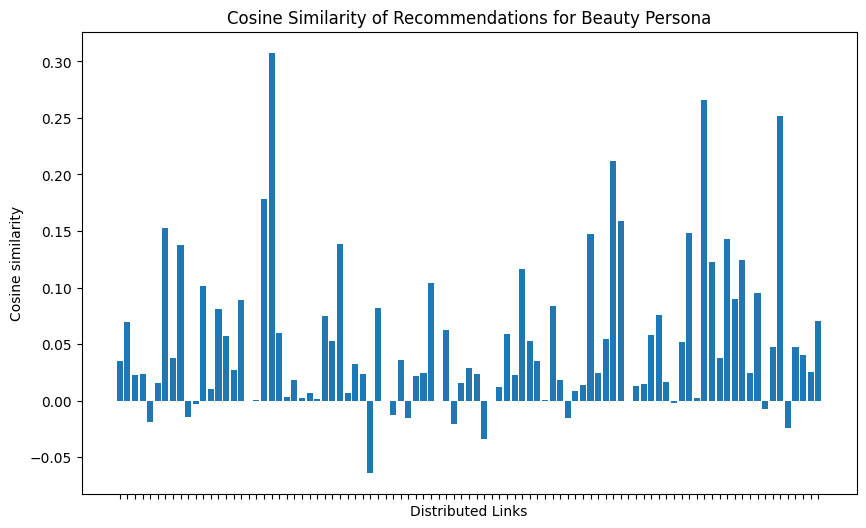

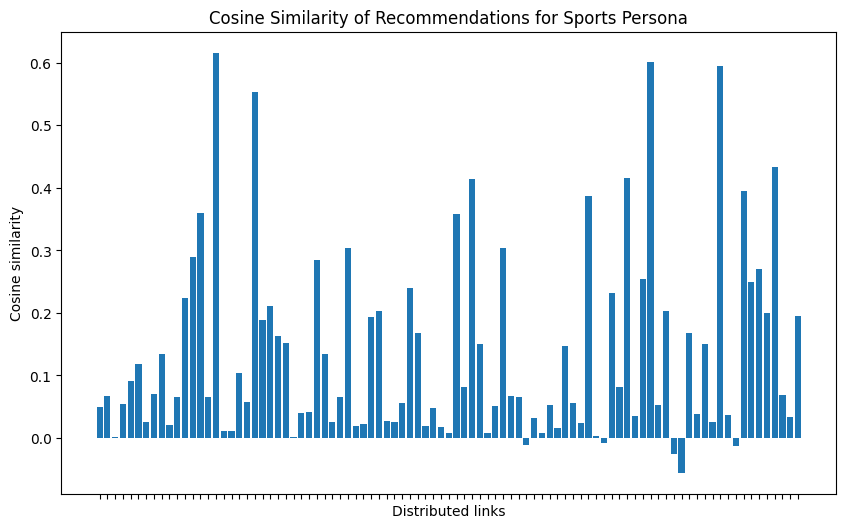

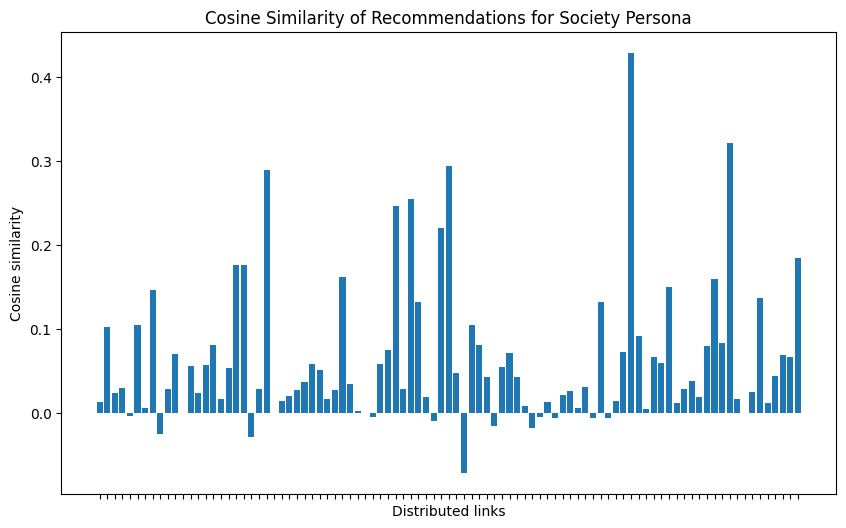

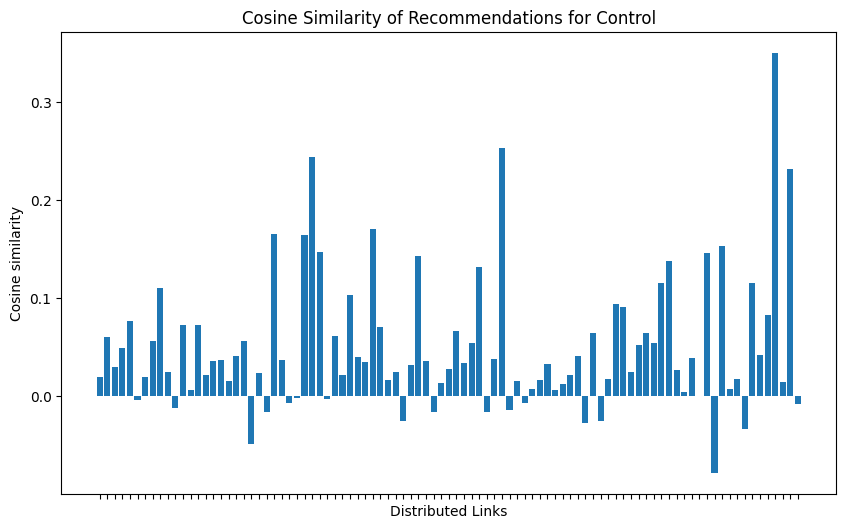

In [109]:
# Beauty
fig = plt.figure(figsize=(10, 6)) 
plt.bar(beauty_df['distributed_link'], beauty_df['cosine_similarity'])
plt.xticks(visible=False)
plt.xlabel("Distributed Links")
plt.ylabel("Cosine similarity")

plt.title("Cosine Similarity of Recommendations for Beauty Persona")
plt.show()

# Sports
fig = plt.figure(figsize=(10, 6)) 
plt.bar(sports_df['distributed_link'], sports_df['cosine_similarity'])
plt.xticks(visible=False)
plt.xlabel("Distributed links")
plt.ylabel("Cosine similarity")

plt.title("Cosine Similarity of Recommendations for Sports Persona")
plt.show()

# Society
fig = plt.figure(figsize=(10, 6)) 
plt.bar(society_df['distributed_link'], society_df['cosine_similarity'])
plt.xticks(visible=False)
plt.xlabel("Distributed links")
plt.ylabel("Cosine similarity")

plt.title("Cosine Similarity of Recommendations for Society Persona")
plt.show()

# Control
fig = plt.figure(figsize=(10, 6)) 
plt.bar(control_df['distributed_link'], control_df['cosine_similarity'])
plt.xticks(visible=False)
plt.xlabel("Distributed Links")
plt.ylabel("Cosine similarity")

plt.title("Cosine Similarity of Recommendations for Control")
plt.show()